In [45]:
import tensorflow.keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.decomposition
import cv2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20,5)

# HW4: Hello Machine Learning

Machine learning has transformed our world. It makes perfect sense you all are interested in how to apply machine learning towards big interesting problems! I hope we get a chance to do that in the remainder of this class.

Machine learning is sometimes called out as "statistics for engineers", and I think it's not too far from the truth. To become proficient in ML you best get hands-on engineering experience, in manipulating data, training algorithms, measuring performance and experiencing over/underfitting first hand.

In this exercise we will practice some simple ML approaches we've seen in class using **Scikit-Learn** - a wonder python package for machine learning, and probably the foremost tool for data scientists today.

The data we will manipulate, being computer vision engineers, is from the **MNIST** hand written digits recognition task. A "Hello World" for computer vision machine learning. Images in this dataset are just $28\times 28$ grayscale pixels.

Here's a sample of the dataset:

In [3]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

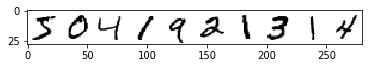

In [4]:
plt.imshow(np.hstack(x_train[:10]), cmap=matplotlib.cm.binary, interpolation='nearest')

We'll start with "Descriptive Statistics", which are a simple statistical exploration of the features in our data. 

Descriptive statistics may be: Mean, Standard Deviation, Correlation between features, etc. 

We will get some help from the great Pandas package for data science.

In [5]:
x_test_df = pd.DataFrame(x_test.reshape(x_test.shape[0],-1))

All the samples in the (test) set flattened as columns:

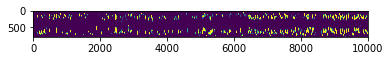

In [6]:
plt.imshow(x_test_df.T);

Mean and standard deviation in each pixel:

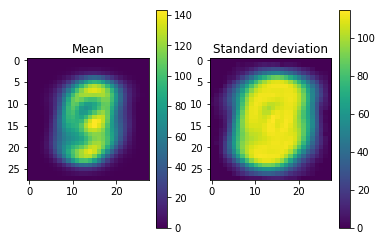

In [7]:
plt.subplot(121),plt.imshow(np.mean(x_test, axis=0)),plt.title("Mean"),plt.colorbar();
plt.subplot(122),plt.imshow(np.std(x_test, axis=0)),plt.title("Standard deviation"),plt.colorbar();

The problem with working with images is that the dimensions are big (here it's 784) and therefore it's hard to visualize. Think about working with images not $28\times28$ but $512\times512$ or even $2048\times2048$! This is not uncommon in computer vision to work in these dimesions.

Sometimes to gain insight to image data we can apply PCA to extarct cross-correlation between features (pixels?).

This will tell us how pixels behave together:

In [8]:
mnist_pca = sklearn.decomposition.PCA().fit(x_test_df)

Show the first 10 principal components:

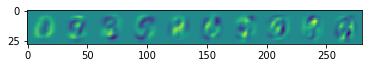

In [9]:
plt.imshow(np.hstack(mnist_pca.components_.reshape(784,28,28)[:10]));

We can see an oval shape is the most prominent direction of change in all digits.

In MNIST the goal is to predict the written digit, which is a classification problem.

How about the disrtibution of categories in our dataset?

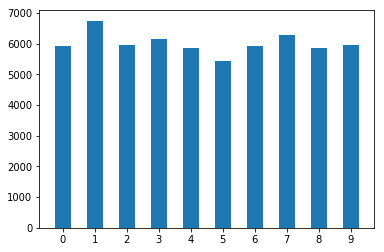

In [10]:
h = np.bincount(y_train)
plt.bar(range(10), h, width=0.5),plt.xticks(range(10));

Seems we have many more '1's than '5's, for example.

## Regression and Classification

Let's build a binary '3' regressor, i.e. which will tell us "how much a '3' is this digit?". This is a job well suited for Logistic Regression.

In [11]:
y_train_3 = np.int32(y_train == 3) # set all 3s to 1, and all else to 0
y_test_3 = np.int32(y_test == 3)   

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
logreg = LogisticRegression()

In [14]:
logreg.fit(x_train.reshape(-1,784)[:6000], y_train_3[:6000]) # use just 6K samples

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Mmmm, that took a very long time!!

As you remember calculating the regression over the full batch of data (60K) is a very heavy, might even be intractable job... Here we only used 6K samples and it took a while, so probably using the full 60K dataset will crash our process.

We can use minibatch or **stochastic gradient descent** to do the work in a fraction of the time.

In [15]:
from sklearn.linear_model import SGDClassifier

This will create an SGD logistic regressor, however it has built-in a *classification* mechanism with an optimal decision boundary.

In [16]:
logreg_sgd = SGDClassifier(loss='log', max_iter=20, tol=-np.infty, random_state=42)

In [17]:
logreg_sgd.fit(x_train.reshape(-1,784), y_train_3)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=20,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

Here are some predictions from the model:

In [18]:
y_pred = logreg_sgd.predict(x_test.reshape(-1,784))

In [19]:
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

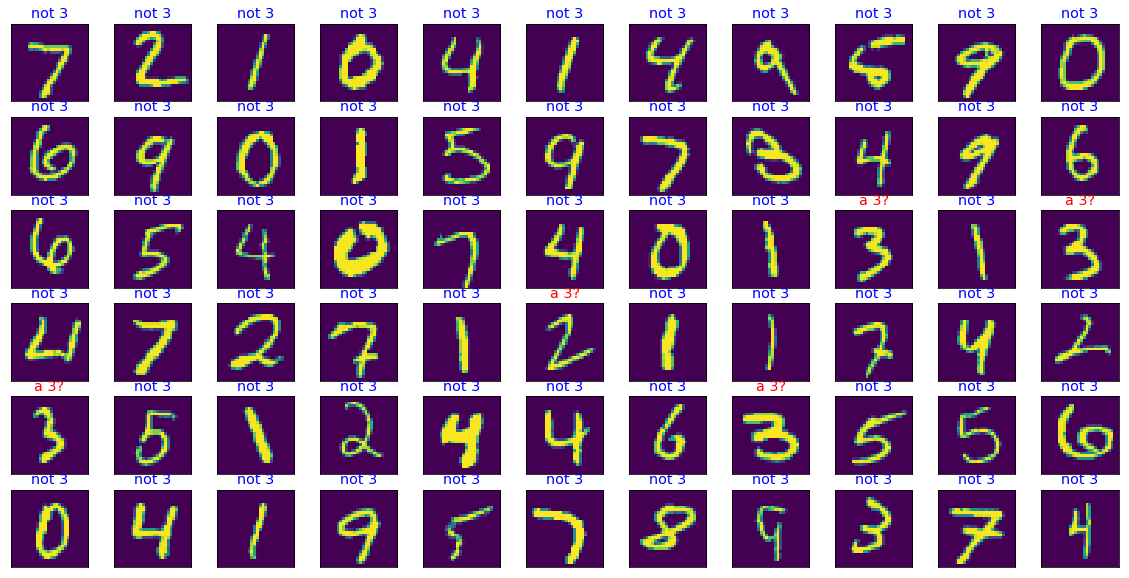

In [20]:
plt.figure(figsize=(20,10))
for i in range(66):
    plt.subplot(6,11,i+1)
    plt.imshow(x_test[i]),plt.xticks([]),plt.yticks([])
    plt.title('a 3?' if y_pred[i] == 1 else 'not 3', color='r' if y_pred[i] == 1 else 'b', fontsize='x-large')

Looks like it got it almost right, but not perfect.

## Performance Evaluation

Let's look at some performance measures like we've seen in class.

In [21]:
from sklearn.metrics import confusion_matrix

A confusion matrix tells us the True Positives, False Positives, False Negatives and True Negatives

|                    | Real Positive | Real Negative |
|:------------------ |:--------------| :-------------:|
| **Predicted Positive** | True Positive | *False* Positive |
| **Predicted Negative** | *False* Negative |   True Negative |


In [22]:
confusion_matrix(y_test_3, y_pred)

array([[8936,   54],
       [ 239,  771]], dtype=int64)

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

- Accuracy is $\frac{TP+TN}{P+N}$ - the "True Rate", proportion of correct predictions (either positive or negative).
- Precision is $\frac{TP}{TP+FP}$ - the proportion of TP to all the *predicted* positives.
- Recall is $\frac{TP}{TP+FN}$ - the proportion of TP to all the *real* positives.

So naturally we'd like to have both precision and recall to be high. 

High precision means our classifier is making more TP than FP. Low amount of FPs is desirable sometimes, in case our system needs to make very little FP mistakes (Type I error), at the expense of rejecting some samples that shouldn't be rejected.

High recall means our classifier is making more TP than FN, rejecting less "real positive" samples and correctly marking them as positive.

The F1-score is the harmonic mean between Precision and Recall and can serve as a single balanced metric to try to increase: $\frac{2TP}{2TP+FP+FN}$.

In [24]:
print("Accuracy:\t", accuracy_score(y_test_3, y_pred))
print("Precision:\t", precision_score(y_test_3, y_pred))
print("Recall:\t\t", recall_score(y_test_3, y_pred))
print("F1 score:\t", f1_score(y_test_3, y_pred))

Accuracy:	 0.9707
Precision:	 0.9345454545454546
Recall:		 0.7633663366336634
F1 score:	 0.8403269754768392


These results are not too bad, but certainly not very good. We're getting high precision but low recall.

For example, the accuracy of a prediction of all "False" (i.e. "Not 3") will be 90%.

**Precision and Recall are at a tradeoff.** 

If we want to get less FPs (increasing Precision) by increasing our detection threshold and only return those predictions of which we are absolutely sure, we will suffer by rejecting more "real positive"s and thus getting more FNs (decreasing Recall).

The `SGDClassifier` picks the best threshold it thinks should be used (over the training set).

Let's look at the threshold over the linear dot-product result that the classifier applies in making a decision, this time over the **Test Set**. The threshold has a direct effect on our precision and recall.

In [25]:
y_scores = logreg_sgd.decision_function(x_test.reshape(-1, 784)) # raw scores

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_3, y_scores)

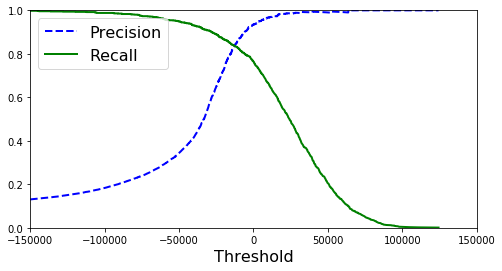

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.ylim([0, 1])
plt.xlim([-150000, 150000])
plt.show()

Let's pick a threshold by ourselves. Looks like a threshold of -15,000 is a good tradeoff between precision and recall.

In [28]:
y_test_pred_best = (y_scores > -15000)

In [29]:
print("Accuracy:\t", accuracy_score(y_test_3, y_test_pred_best))
print("Precision:\t", precision_score(y_test_3, y_test_pred_best))
print("Recall:\t\t", recall_score(y_test_3, y_test_pred_best))
print("F1 score:\t", f1_score(y_test_3, y_test_pred_best))

Accuracy:	 0.9634
Precision:	 0.803201506591337
Recall:		 0.8445544554455445
F1 score:	 0.8233590733590733


We were able to improve on all the metrics by adjusting the threshold to better perform on the test set.

Plotting precision vs. recall w.r.t the threshold may also help us understand the inverse relationship.

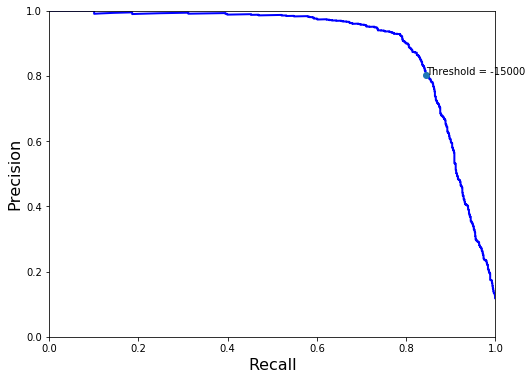

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
threshold_pos = np.searchsorted(thresholds, -15000)
thresh_point = (recalls[threshold_pos], precisions[threshold_pos])
plt.plot(thresh_point[0], thresh_point[1], 'o')
plt.annotate("Threshold = -15000", xy=thresh_point)
plt.axis([0, 1, 0, 1])
plt.show()

At $t = -15,000$ the precision and recall are maximal.

## Cross validation

But how would we know to select the threshold? In a real system we cannot tweak the threshold based on our evaluation set, only the training.

We could simulate this situation if we would pick the validation set randomly and repeat a number of times. This is called K-fold cross-validation.

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

best_clf = None
best_f1 = 0
for train_index, test_index in skfolds.split(x_train, y_train_3):
    clone_clf = clone(logreg_sgd)
    X_train_folds = x_train[train_index]
    y_train_folds = (y_train_3[train_index])
    X_test_fold = x_train[test_index]
    y_test_fold = (y_train_3[test_index])

    clone_clf.fit(X_train_folds.reshape(-1,784), y_train_folds)
    y_pred = clone_clf.predict(X_test_fold.reshape(-1,784))
    f1 = f1_score(y_test_fold, y_pred)
    print("F1 score", f1)
    if f1 > best_f1:
        best_clf = clone_clf

F1 score 0.803606773696943
F1 score 0.824435318275154
F1 score 0.765601544070341


In [32]:
print("Test F1", f1_score(y_test_3, best_clf.predict(x_test.reshape(-1,784))))

Test F1 0.7700214132762313


We now have a slightly better classifier. Our classifier before got 0.76 F1 score on the test set.

## Overfitting and Underfitting

Let's examine the learning curves of the SGD predictor as it progressively trains on the training set.

In [33]:
# get a fresh logistic regression classifier
logreg_sgd = SGDClassifier(loss='log', max_iter=1, random_state=42, penalty='none')

Taking a batch size of 1024 samples, we feed the data one batch at a time allowing the learner to update its weights. We measure the loss and accuracy.

Repeat this process for 20 "Epochs" - an Epoch (usually) is a single run over the entire dataset.

In [34]:
from sklearn.metrics import log_loss

BATCH_SIZE = 1024
num_batches = x_train.shape[0]//BATCH_SIZE

train_avg_loss = []
val_loss = []
val_acc = []
train_losses = []
for ei in range(5):
    for bi in range(num_batches):
        start_idx, end_idx = bi*BATCH_SIZE, (bi+1)*BATCH_SIZE
        x_batch = x_train[start_idx:end_idx].reshape(-1,784)
        y_batch = y_train_3[start_idx:end_idx]

        logreg_sgd.partial_fit(x_batch, y_batch, classes=[0,1])

        train_losses.append(log_loss(y_batch, logreg_sgd.predict(x_batch)))
            
        y_pred = logreg_sgd.predict(x_test.reshape(-1,784))
        val_loss.append(log_loss(y_test_3, y_pred))
        val_acc.append(accuracy_score(y_test_3, y_pred))

    print("EPOCH %d"%ei)

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

EPOCH 0


C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

EPOCH 1


C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

EPOCH 2


C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

EPOCH 3


C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda\envs\cv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If

EPOCH 4


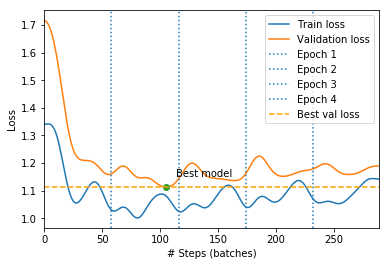

In [35]:
from scipy.ndimage.filters import gaussian_filter1d

smooth_val_loss = gaussian_filter1d(val_loss, sigma=8)
smooth_train_loss = gaussian_filter1d(train_losses, sigma=8)
plt.plot(smooth_train_loss, label='Train loss')
plt.plot(smooth_val_loss, label='Validation loss')
for i,v in enumerate(np.arange(0,len(val_loss),x_train.shape[0]//BATCH_SIZE)[1:]):
    plt.axvline(v, linestyle=':', label='Epoch %d'%(i+1))
plt.xlabel('# Steps (batches)')
plt.ylabel('Loss')
plt.xlim(0, len(val_loss)-1)
best_model_step = np.argmin(smooth_val_loss)
best_model_pt = (best_model_step,smooth_val_loss[best_model_step])
plt.plot(best_model_pt[0], best_model_pt[1], 'o')
plt.annotate('Best model', xy=best_model_pt, xytext=(10,10), textcoords='offset points')
plt.axhline(y=best_model_pt[1], linestyle="--", color='orange', label='Best val loss')
plt.legend();

This looks like overfitting. There's a gap between the validation loss and the training loss, and the *training loss* is actually **increasing**.

Beyond the best model point the **validation loss is increasing**, therefore **overfitting**.

Before the best model point the **validation loss is decreasing**, therefore **underfitting**.

We can apply "Early Stopping" to stop training when this happens. The `SGDClassifier` has an early stopping option.

---
---
# Here comes your part!


We're going to create our very own Viola-Jones-ish **face detector** with Haar-like binary features and an **AdaBoost classifier based on 1-level Decision Trees** (basically a single split based on a single feature).

Load the data: (based on the [FDDB](http://vis-www.cs.umass.edu/fddb/))

In [36]:
import requests
import io

dl_id = '1rl8vLb8VBBC0Fi41Ueg017rzvbh3bKPA'
data = np.load(io.BytesIO(requests.get("https://drive.google.com/uc?id=%s"%(dl_id)).content))
faces = data['faces']
not_faces = data['not_faces']

### Faces

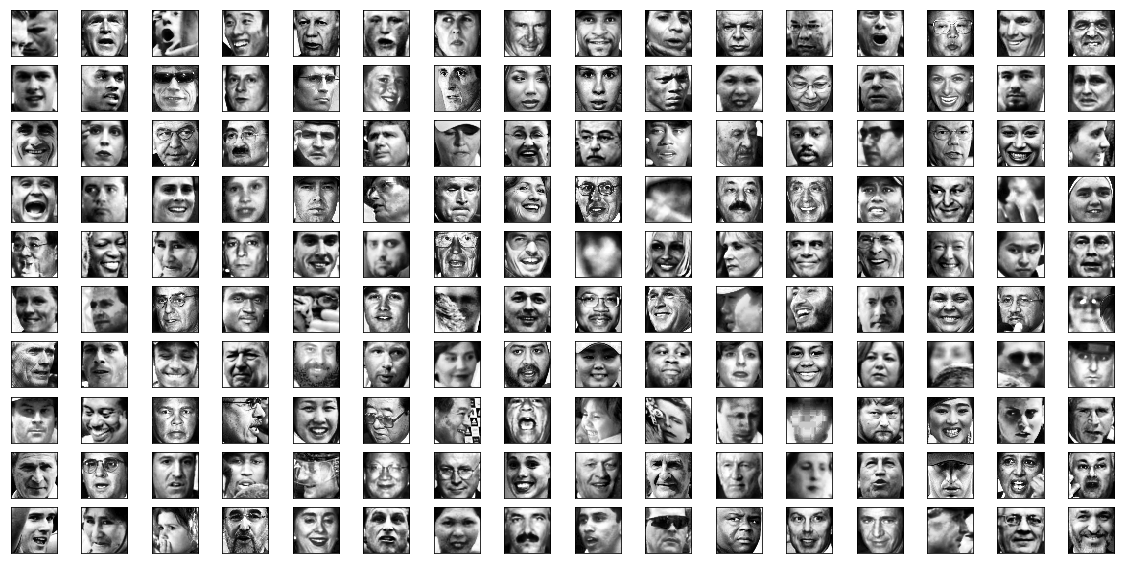

In [37]:
plt.figure(figsize=(20,10))
for i in range(160):
    plt.subplot(10,16,i+1)
    plt.imshow(faces[np.random.randint(0,len(faces))], cmap='gray')
    plt.xticks([]),plt.yticks([])

### Not Faces

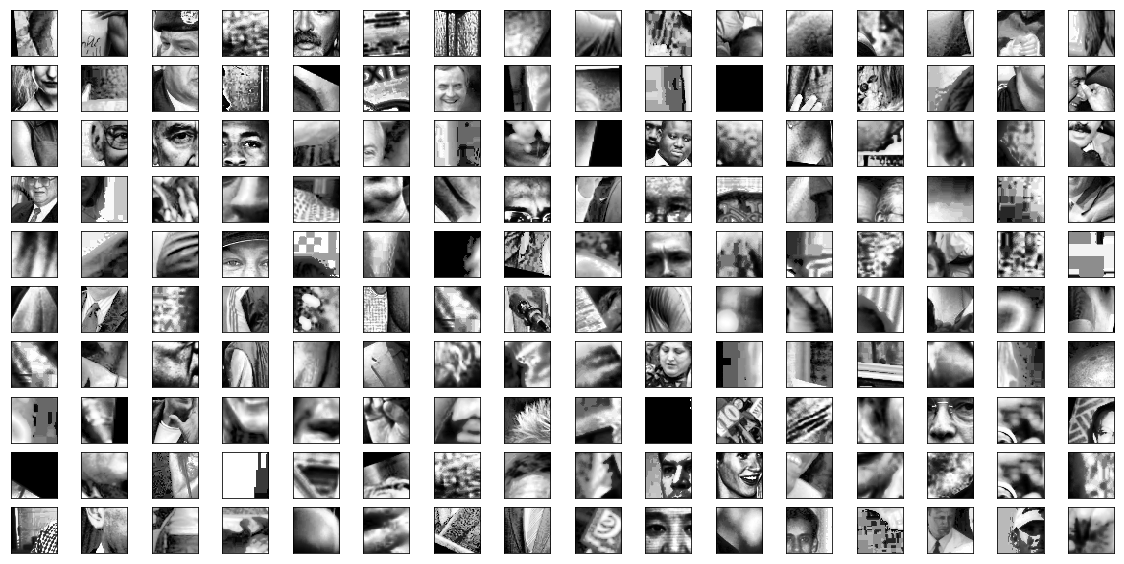

In [38]:
plt.figure(figsize=(20,10))
for i in range(160):
    plt.subplot(10,16,i+1)
    plt.imshow(not_faces[np.random.randint(0,len(not_faces))], cmap='gray')
    plt.xticks([]),plt.yticks([])

Put all samples (positive + negative) in a single array and create a binary annotation {0,1}:

In [39]:
X_faces = np.vstack([faces, not_faces])
y_faces = np.array([1] * len(faces) + [0] * len(not_faces))

### Create Haar-like binary features
Randomize 1000 Haar-like binary features:
1. Randomize width & height (range [min,max] = [10,30])
1. Randomize feature type: horizontal/vertical + 2-split/3-split (total 4 types)
1. Randomize x,y (make sure not exceed image bounds)

In [40]:
# util function to draw a Haar-like feature
def draw_haar_feature(im, haar_feature):
    x,y,w,h,ft = haar_feature
    x1,y1 = x + w, y + h
    xmid,ymid = int(x+w/2.),  int(y+h/2.)
    x13,y13   = int(x+w/3.),  int(y+h/3.)
    x23,y23   = int(x+2*w/3.),int(y+2*h/3.)
    assert(ft < 4 and ft >= 0)

    if ft == 0:
        cv2.rectangle(im, (x,y),    (x1,ymid), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x,ymid), (x1,y1), (255,0,0), 1)
    if ft == 1:
        cv2.rectangle(im, (x,y),    (xmid,y1), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (xmid,y), (x1,y1), (255,0,0), 1)
    if ft == 2:
        cv2.rectangle(im, (x,y),   (x1,y13), (255,0,0), 1)
        cv2.rectangle(im, (x,y13), (x1,y23), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x,y23), (x1,y1), (255,0,0), 1)
    if ft == 3:
        cv2.rectangle(im, (x,y),   (x13,y1), (255,0,0), 1)
        cv2.rectangle(im, (x13,y), (x23,y1), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x23,y), (x1,y1), (255,0,0), 1)
    return im

In [41]:
NUM_HAAR_FEATURES = 1000

Randomize the feature coordinates:

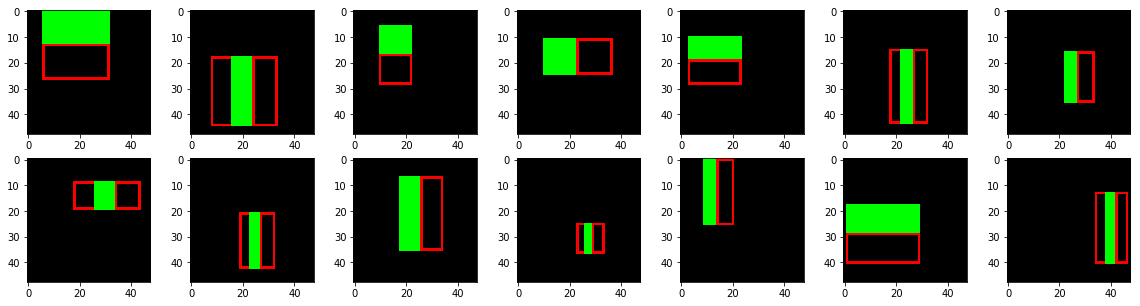

In [46]:
import random

haar_features_im = np.zeros((48,48,3),np.uint8)
haar_features = []

np.random.seed(42) # make sure results are repeatable
for i in range(NUM_HAAR_FEATURES):
   
    w, h = random.randint(10,30),random.randint(10,30)
    x = random.randint(0,48-w-1)
    y = random.randint(0,48-h-1)
    ft = random.randint(0,3)
    haar_features.append((x,y,w,h,ft))
    if i < 14:
        plt.subplot(2,7,i+1)
        plt.imshow(draw_haar_feature(haar_features_im.copy(), haar_features[-1]))

### Calculate responses
Calculate the feature responses for all samples, using the integral image.
Create a dataset of shape: (\[num_samples\], 1000)

In [47]:
def ii_sum(ii, x0, y0, x1, y1):
    return ii[y1,x1]+ii[y0,x0]-ii[y0,x1]-ii[y1,x0]

def extract_haar_features(imgray, haar_features_):
    ii = cv2.integral(imgray)
    feature_responses = []
    for (x0,y0,w,h,ft) in haar_features_:
        x1,y1 = x0 + w, y0 + h
        xmid,ymid = int(x0+w/2.),int(y0+h/2.)
        x13,y13 = int(x0+w/3.),int(y0+h/3.)
        x23,y23 = int(x0+2*w/3.),int(y0+2*h/3.)

        if ft == 0: # Horizontal 2-split
            feature_response = -ii_sum(ii,x0,ymid,x1,y1) + ii_sum(ii,x0,y0,x1,ymid)
        if ft == 1: # Vertical 2-split
            feature_response = -ii_sum(ii,xmid,y0,x1,y1) + ii_sum(ii,x0,y0,xmid,y1)
        if ft == 2: # Horizontal 3-split
            feature_response = ii_sum(ii,x0,y23,x1,y1) -ii_sum(ii,x0,y13,x1,y23) + ii_sum(ii,x0,y0,x1,y13)
        if ft == 3: # Vertical 3-split
            feature_response = ii_sum(ii,x0,y0,x13,y1) -ii_sum(ii,x13,y0,x23,y1) + ii_sum(ii,x23,y0,x1,y1)

        feature_responses.append(feature_response)
        
    return feature_responses

In [48]:
X_faces_features = []
for i in range(len(X_faces)):
    X_faces_features.append(extract_haar_features(X_faces[i], haar_features))

Shuffle and split the dataset to training and testing

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_faces_features, y_faces, random_state=42)

### Create and train an Adaptive Boosting classifier

In [51]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

Define an AdaBoost classifier with just 20 estimators (each estimator is a depth-1 decision tree).

In [52]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=20)

Train the model on the training data

In [53]:
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=20, random_state=None)

Show the selected features in each weak classifier: (decreasing order of power)

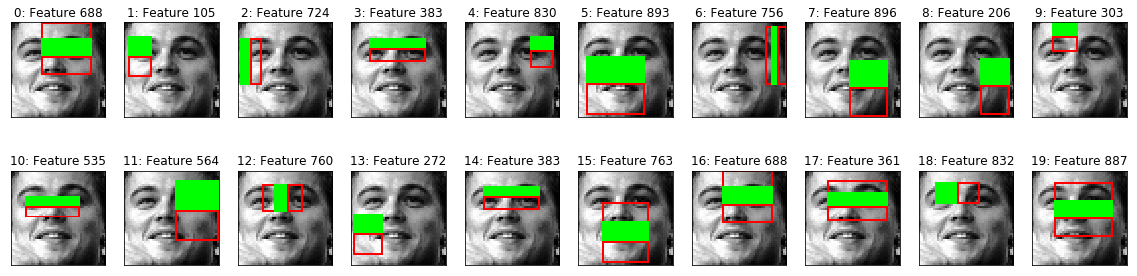

In [54]:
for i in range(20):
    haar_features_im = cv2.cvtColor(X_faces[14],cv2.COLOR_GRAY2RGB).copy()
    draw_haar_feature(haar_features_im, haar_features[bdt.estimators_[i].tree_.feature[0]])
    plt.subplot(2,10,i+1)
    plt.imshow(haar_features_im),plt.title("%d: Feature %d"%(i, bdt.estimators_[i].tree_.feature[0]))
    plt.xticks([]),plt.yticks([])

As you can see the selected features are quite indicative of whether there is a face in the image, mostly concerned with the eyes area.

We can also visualize how much classification error each weak estimator has:

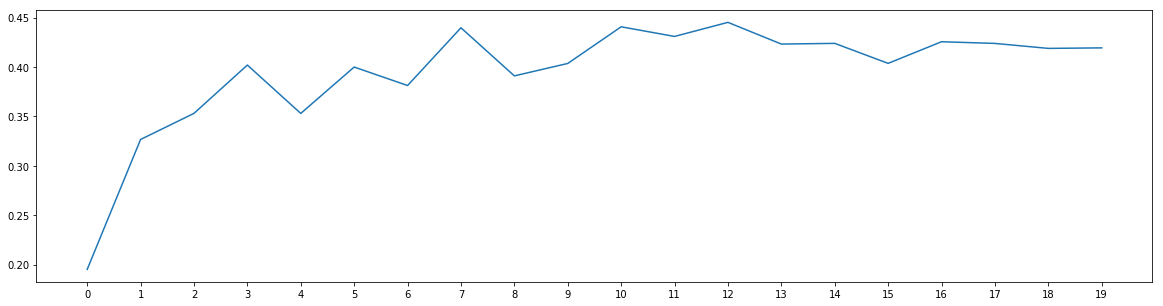

In [55]:
plt.plot(bdt.estimator_errors_),plt.xticks(range(20));

It's obvious that the first few features are the better ones with minimum error in classification, which is why they were selected first.

We can evaluate our classifier on the test set:

In [56]:
y_pred = bdt.predict(X_test)
# TODO: print the accuracy, precision, recall and f1 score
print("Accuracy:\t",  accuracy_score(y_pred,y_test))
print("Precision:\t", precision_score(y_pred,y_test))
print("Recall:\t\t", recall_score(y_pred,y_test))
print("F1 score:\t", f1_score(y_pred,y_test))

Accuracy:	 0.873574144486692
Precision:	 0.8688524590163934
Recall:		 0.8739088263821533
F1 score:	 0.8713733075435203


The classifier gets a pretty high F1 score ($\sim$0.88), which means it is well balanced between precision and recall.

### Hyperparameter Tuning
Let's try to find the optimal number of estimators, since 20 is pretty arbitrary.

Using a "Grid Search" we can test different values of the parameter.

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [15, 20, 30, 50, 80]}]

adb_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
grid_search = GridSearchCV(adb_clf, param_grid, cv=2, verbose=3, n_jobs=1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] n_estimators=15 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ n_estimators=15, score=0.8840671523598352, total=   7.0s
[CV] n_estimators=15 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] ........ n_estimators=15, score=0.8757527733755943, total=   7.7s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s


[CV] ........ n_estimators=20, score=0.8900855242318657, total=   9.7s
[CV] n_estimators=20 .................................................
[CV] ........ n_estimators=20, score=0.8786053882725832, total=   7.4s
[CV] n_estimators=30 .................................................
[CV] ........ n_estimators=30, score=0.8999049730757048, total=  11.0s
[CV] n_estimators=30 .................................................
[CV] ......... n_estimators=30, score=0.887797147385103, total=  10.9s
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=50, score=0.9030725372188787, total=  19.2s
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=50, score=0.9049128367670365, total=  23.3s
[CV] n_estimators=80 .................................................
[CV] ........ n_estimators=80, score=0.9144757681343048, total=  38.3s
[CV] n_estimators=80 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.9min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'n_estimators': [15, 20, 30, 50, 80]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

Which is the best model?

In [60]:
grid_search.best_estimator_.n_estimators

80

As expected the 80-features model is the best, with the highest accuracy. If we would have increased that number futher we would expect to see some overfitting.

In [61]:
y_pred = grid_search.best_estimator_.predict(X_test)

# TODO: print the accuracy, precision, recall and f1 score
print("Accuracy:\t",  accuracy_score(y_pred,y_test))
print("Precision:\t", precision_score(y_pred,y_test))
print("Recall:\t\t", recall_score(y_pred,y_test))
print("F1 score:\t", f1_score(y_pred,y_test))

Accuracy:	 0.9025665399239544
Precision:	 0.896817743490839
Recall:		 0.9046692607003891
F1 score:	 0.9007263922518159


However, the added benefit of the 60 additional features (!!) over our 20-features model translates to just 0.02 increase in F1, which is neglegible. We can probably do just as well with the 15-features model as well, and gain a significant speed boost.

### Detect faces in an image
To detect a face, simply run the classifier over a $50\times50$ sliding window in the image.

In [62]:
def load_image(url):
    im = cv2.imdecode(np.frombuffer(requests.get(url).content, np.uint8), cv2.IMREAD_COLOR)[...,::-1]
    return im

In [63]:
im = cv2.resize(load_image("http://dailypost.ng/wp-content/uploads/2017/06/ronaldo-messi.jpg"), (0,0),fx=0.5,fy=0.5)


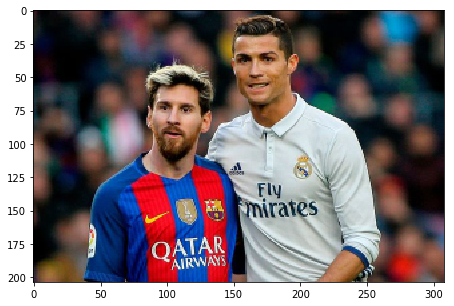

In [64]:
plt.imshow(im);

The gentelmen in this image are [Shimon Peres](https://en.wikipedia.org/wiki/Shimon_Peres) and [Ariel Sharon](https://en.wikipedia.org/wiki/Ariel_Sharon), two former Israeli prime ministers.

Now, instead of calculating all of the 1000 Haar-like features, we need only to calculate the ones selected by our 20-feature classifier. But - we need to place them in the right position in the 1000-long feature vector so that the classifier will pick them up (as if all of the 1000 were calculated).

This will immensly increase the calculation time, having to evaluate the response for just 20 features instead of 1000.

In [65]:
# Gather just the 20 selected features and their index in the original 1000-long vector
haar_features_selected = {est.tree_.feature[0]: haar_features[est.tree_.feature[0]] for est in bdt.estimators_}
haar_features_selected_keys = list(haar_features_selected.keys())
haar_features_selected_values = list(haar_features_selected.values())

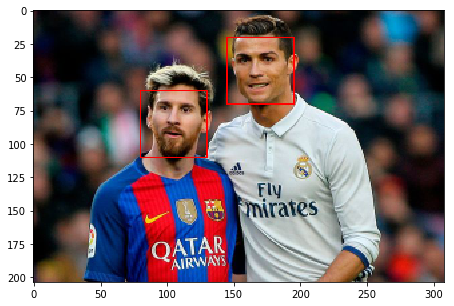

In [69]:
imgray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
imdebug = im.copy()
w, h = imgray.shape

for x in range(0,w-50,5):
    for y in range(0,h-50,5):
        crop = cv2.equalizeHist(imgray[x:x+50,y:y+50])

        features = extract_haar_features(crop, haar_features_selected_values)
        features_expanded = np.zeros((1, NUM_HAAR_FEATURES))
        for i in range(len(features)): # re-place the calculated features in the vector
            features_expanded[0, haar_features_selected_keys[i]] = features[i]
        pred = bdt.predict_proba(features_expanded)
        if pred[0,1] >0.58:
            cv2.rectangle(imdebug, (y,x),   (y+50,x+50), (255,0,0), 1)
            
        
plt.imshow(imdebug);

How about that for a face detector? Based on just 20 binary features, it's pretty nifty...

The actual method further speeds thing up by running each weak estimator in order and breaking early if chances are low to get a positive prediction.

That's a wrap!